# Installing texthero package.
**By using this package we can clean the data set required for model building by removing stop words punctations etc**

In [ ]:
!pip install texthero

     |████████████████████████████████| 235 kB 7.1 MB/s 
     |████████████████████████████████| 1.5 MB 42.7 MB/s 
     |████████████████████████████████| 749 kB 66.2 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


**Required python packages for preprocessing**

In [ ]:
import pandas as pd
import texthero as hero
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import re
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#connecting cloab notebook with google collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
claims_data = pd.read_csv('/content/drive/MyDrive/MyLearning_using_raspberry_pi/Virtusa/MIMIC-III-Final.csv.zip (Unzipped Files)/MIMIC-III-Final.csv')
claims_data.head()

,Unnamed: 0,TEXT,HADM_ID,ICD9_CODE
0,0,{Admission Date: [**2117-9-11**] ...,100001.0,"['25013', '3371', '5849', '5780', 'V5867', '25..."
1,1,{Admission Date: [**2150-4-17**] ...,100003.0,"['53100', '2851', '07054', '5715', '45621', '5..."
2,2,{Admission Date: [**2108-4-6**] Dischar...,100006.0,"['49320', '51881', '486', '20300', '2761', '78..."
3,3,{Admission Date: [**2145-3-31**] ...,100007.0,"['56081', '5570', '9973', '486', '4019']"
4,4,{Admission Date: [**2162-5-16**] ...,100009.0,"['41401', '99604', '4142', '25000', '27800', '..."


**Python script to extract keywords from the dataset text column to decide the features to extract**

In [ ]:
def covert_list_dict(l):
  unique_list = list(set(l))
  dic = {}
  for i in unique_list:
    dic[i] = l.count(i)
  return dic

def get_keywords(text):
  original_text = text
  doubt_index = [_.start() for _ in re.finditer(':',text)] 
  if len(doubt_index)>1:
    result = []
    for i in doubt_index:
      text = original_text
      text = text[:i]
      stop_index_dot = text[:i].rfind("\.")
      stop_index_line = text[:i].rfind("\n")
      stop_index = max(stop_index_dot,stop_index_line)
      hopi = text[stop_index:i]
      output = True
      for i in range(10):
        a = hopi.find(str(i))
        if a!=-1:
          output = False
      if output:
          result.append(hopi)
    dic_output = covert_list_dict(result)
    return dic_output

**Extracted keywords with the frequency count**

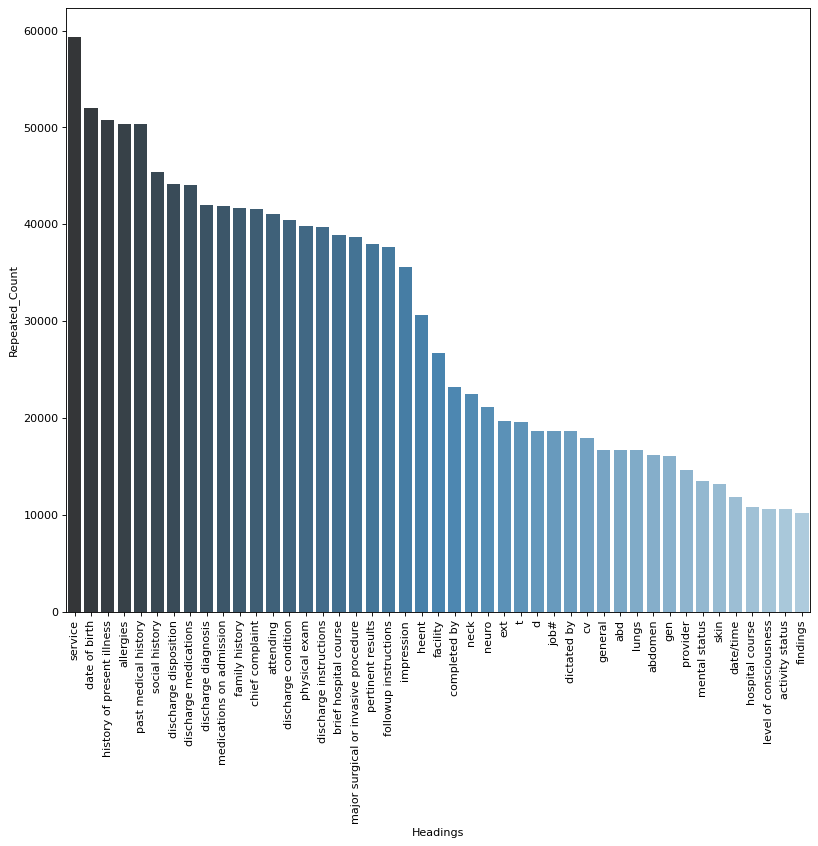

In [ ]:
df_headings = pd.read_csv('/content/drive/MyDrive/MyLearning_using_raspberry_pi/Virtusa/MIMIC-III-Final.csv.zip (Unzipped Files)/Headings_count_data.csv')
df1_headings = df_headings.sort_values("Repeated_Count",axis=0,ascending=False)
df1_headings = df1_headings[2:]
df2_headings = df1_headings.head(45)
df2_headings.reset_index(drop=True,inplace=True)
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=80)
ranks = df2_headings["Repeated_Count"].sort_values().index
palette = sns.color_palette('Blues_d',len(ranks))
ax = sns.barplot(x='Headings',y='Repeated_Count',palette=np.array(palette)[ranks],data=df2_headings)
L = df2_headings["Headings"].tolist()
for item in ax.get_xticklabels():
  item.set_rotation(90)

**Select 11 columns based on the frequency and importance of them in the health domain**


1.   Gender
2.   history_of_present_illness
1.   past_medical_history
2.   social_history
1.   family_history
2.   physical_exam
1.   chief_complaint
2.   medications_on_admission
1.   major_surgical_or_invasive_procedure
2.   discharge_diagnosis
1.   discharge_condition



**Python script to extract the above 11 features from the raw text data in the dataset**

In [ ]:
def extract_column_values(text,column_value):
  index = text.find(column_value)
  original_text = text
  doubt_index = [_.start() for _ in re.finditer(column_value,text)] 
  if len(doubt_index)>1:
    result = ""
    for i in doubt_index:
      text = original_text
      text = text[i+len(column_value):]
      colon_index = text.find(':')
      stop_index_dot = text[:colon_index].rfind("\.")
      stop_index_line = text[:colon_index].rfind("\n")
      stop_index = max(stop_index_dot,stop_index_line)
      hopi = text[:stop_index]
      result += hopi
    return result.strip()

  if index == -1:
    return np.nan
  text = text[index+len(column_value):]
  colon_index = text.find(':')
  stop_index_dot = text[:colon_index].rfind("\.")
  stop_index_line = text[:colon_index].rfind("\n")
  stop_index = max(stop_index_dot,stop_index_line)
  hopi = text[:stop_index]
  return hopi.strip()

#Example we can all of them with same process as below. it showing for social-history
#claims_data = claims_data.assign(social_history = lambda x : [extract_column_values(i,'social history:') for i in x['TEXT'] ])
#claims_data['social_history'] = claims_data['social_history'].replace({"":np.nan})

In [ ]:
#Extracted dataset with 11 features
claims_data = pd.read_csv('/content/drive/MyDrive/MyLearning_using_raspberry_pi/Virtusa/MIMIC-III-Final.csv.zip (Unzipped Files)/Extract_features/11_features.csv')
claims_data.head(3)


,TEXT,HADM_ID,ICD9_CODE,Gender,history_of_present_illness,past_medical_history,social_history,discharge_diagnosis,medications_on_admission,family_history,chief_complaint,discharge_condition,physical_exam,major_surgical_or_invasive_procedure
0,{admission date: [**2117-9-11**] ...,100001.0,"['25013', '3371', '5849', '5780', 'V5867', '25...",f,35f w/ poorly controlled type 1 diabetes melli...,"type 1 diabetes mellitis w/ neuropathy, nephro...",patient lives at home in [**location (un) **] ...,diabetic keotacidosis\nhematemesis (blood in y...,NaN,both parents have htn and t2dm. grandfather ha...,"nausea, vomiting",NaN,":\ngen: awake, alert, and oriented\nheent: per...",none
1,{admission date: [**2150-4-17**] ...,100003.0,"['53100', '2851', '07054', '5715', '45621', '5...",m,mr. [**known lastname 52368**] is a 59m w hepc...,hcv cirrhosis (tx with interferon x2 with no r...,"he lives alone. he is drinking alcohol, usual...",peptic ulcer\ngi bleed,furosemide 20mg daily\nlisinopril 10 mg daily\...,nc,coffee ground emesis,asymptomatic,:\non admission:\nvs: t95.9 hr 71 bp 83/36 rr ...,egd\nright ij cvl
2,{admission date: [**2108-4-6**] dischar...,100006.0,"['49320', '51881', '486', '20300', '2761', '78...",f,this is a 48 year old african\namerican female...,1. multiple myeloma diagnosed in [**2107-12-9...,"socially, she lives with her children and\nwor...",NaN,NaN,family history shows father died of an\nmyocar...,dyspnea.,NaN,"ination upon admission: temperature, 96.6;\nh...",NaN


**Done Data cleaning for those 11 features**

In [ ]:
L = list(claims_data.columns)[3:]
L

['Gender',
 'history_of_present_illness',
 'past_medical_history',
 'social_history',
 'discharge_diagnosis',
 'medications_on_admission',
 'family_history',
 'chief_complaint',
 'discharge_condition',
 'physical_exam',
 'major_surgical_or_invasive_procedure']

In [ ]:
# replace the matching strings
claims_data = claims_data.replace(to_replace ='\[\*+.*\*+\]', value = ' ', regex = True)

# let's do text preprocessing
from texthero import preprocessing

# creating a custom pipeline to preprocess the raw text we have
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                  #  , preprocessing.remove_digits # you can uncomment this if you want to remove digits as well.
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_stopwords
                   , preprocessing.remove_whitespace
                   , preprocessing.stem]

# simply call clean() method to clean the raw text in 'TEXT' col and pass the custom_pipeline to pipeline argument
count = 0
for i in L:
    claims_data[i] = hero.clean(claims_data[i], pipeline = custom_pipeline)
    count+=1

In [ ]:
claims_data.head(2)

,TEXT,HADM_ID,ICD9_CODE,Gender,history_of_present_illness,past_medical_history,social_history,discharge_diagnosis,medications_on_admission,family_history,chief_complaint,discharge_condition,physical_exam,major_surgical_or_invasive_procedure
0,{admission date: \n\ndate of birth: ...,100001.0,"['25013', '3371', '5849', '5780', 'V5867', '25...",f,35f w poor control type 1 diabet mellitus w ne...,type 1 diabet melliti w neuropathi nephropathi...,patient live home 8 daughter boyfriend histori...,diabet keotacidosi hematemesi blood vomit hype...,,parent htn t2dm grandfath mi 40s,nausea vomit,,gen awak alert orient heent perrla mmm jvd nec...,none
1,{admission date: \n\ndate of birth: ...,100003.0,"['53100', '2851', '07054', '5715', '45621', '5...",,mr 59m w hepc cirrhosi c b grade ii esophag va...,hcv cirrhosi tx interferon x2 respons portal g...,live alon drink alcohol usual one session per ...,peptic ulcer gi bleed,furosemid 20mg daili lisinopril 10 mg daili sp...,nc,coffe ground emesi,asymptomat,admiss vs t95 9 hr 71 bp 83 36 rr 11 96 2l nc ...,egd right ij cvl


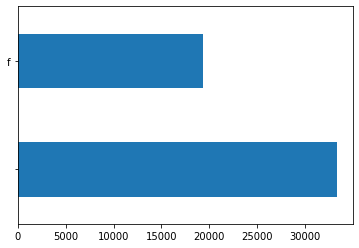

In [ ]:
temp = claims_data['Gender'].value_counts()
temp.plot(kind='barh')